In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [2]:
import keras.backend as K
import keras.layers as layers
from keras.models import Model
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pyjet import cluster,DTYPE_PTEPM
import pandas as pd

In [4]:
# use this cell to make a smaller input file for testing purposes

#d = pd.read_hdf("events.h5")
#np.save('events_small.npy', d[:100000])

In [5]:
d = pd.DataFrame(np.load('events_small.npy'))
d.shape

(100000, 2101)

In [6]:
# masks for bg and signal events
is_bg = (d[2100] == 0)
is_sig = (d[2100] == 1)

In [7]:
print("N_bg  = %d"%np.sum(is_bg))
print("N_sig = %d"%np.sum(is_sig))
print("N_tot = %d"%(np.sum(is_bg) + np.sum(is_sig)))

N_bg  = 90941
N_sig = 9059
N_tot = 100000


In [8]:
# pull out the bg and signal events separately, and reshape to (Nevt, Nparticle, 3)
# the last axis is (pT,eta,phi)

bg = d[is_bg].to_numpy()[:,:-1].reshape((-1,700,3))
sig = d[is_sig].to_numpy()[:,:-1].reshape((-1,700,3))

In [9]:
print(sig.shape)
print(bg.shape)

(9059, 700, 3)
(90941, 700, 3)


In [10]:
# Takes an input of shape (Nevt, Nparticle, 3), and returns a tuple (jets, consts):
# `jets` is a list containing the (pt, eta, phi, m) for the leading jet in each event
# `consts` is a list containing the (pt, eta, phi) for the leading `ntrk` particles in the jet.

def cluster_jets(evts, ntrk=16, minpt=1600, gev=False):
    ljets = np.zeros((len(evts), 4))
    consts = np.zeros((len(evts), ntrk, 3))
    
    unit = 1e3 if gev else 1.0
    
    arr = np.zeros(700, dtype=DTYPE_PTEPM)
    for i,evt in enumerate(evts):
        #pt = evt[0::3]
        pt = evt[:,0]
        mask = pt>0
        n = np.sum(mask)
        pt = pt[mask]
        eta = evt[:,1][mask]
        phi = evt[:,2][mask]
        pj_input = arr[:n]
        pj_input['pT'] = pt*unit
        pj_input['eta'] = eta
        pj_input['phi'] = phi
        sequence = cluster(pj_input, R=1.0, p=-1)
        jets = sequence.inclusive_jets(ptmin=20)

        if len(jets) < 1:
            continue
        
        j0 = jets[0]
        
        
        c0 = j0.constituents_array()
        c0[::-1].sort()
        nc = min(c0.shape[0], ntrk)
        
        if c0.shape[0] < ntrk:
            continue
            
        ljets[i] = (j0.pt, j0.eta, j0.phi, j0.mass)
        
        consts[i][:nc,0] = c0[:nc]['pT']
        consts[i][:nc,1] = c0[:nc]['eta']
        consts[i][:nc,2] = c0[:nc]['phi']
        
    sel = ljets[:,0] > minpt
    ljets = ljets[sel]
    consts = consts[sel]
    
    return ljets, consts

In [11]:
# cluster jets, requiring pT>1.6 TeV

ntrk = 32
minpt = 1600

bg_jets, bg_consts = cluster_jets(bg, ntrk=ntrk, minpt=minpt)
sig_jets, sig_consts = cluster_jets(sig, ntrk=ntrk, minpt=minpt)

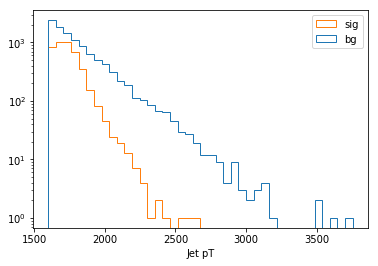

In [12]:
plt.hist([bg_jets[:,0], sig_jets[:,0]], histtype='step', bins=40, label=['bg','sig'])
plt.yscale('log')
plt.xlabel("Jet pT")
plt.legend();

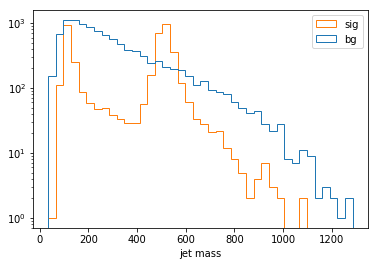

In [13]:
plt.hist([bg_jets[:,3], sig_jets[:,3]], histtype='step', bins=40, label=['bg', 'sig'])
plt.yscale('log');
plt.xlabel("jet mass")
plt.legend();

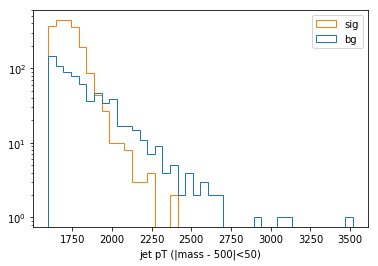

In [14]:
plt.hist([bg_jets[:,0][np.abs(bg_jets[:,3]-500)<50], sig_jets[:,0][np.abs(sig_jets[:,3]-500)<50]], histtype='step', bins=40, label=['bg','sig'])
plt.yscale('log');
plt.xlabel("jet pT (|mass - 500|<50)")
plt.legend();

In [15]:
# Format the dataset for input to the NN.
# First stack to together data from the two classes

X = np.concatenate([bg_consts, sig_consts], axis=0).copy()

# convert pT units to TeV (to limit range of inputs to NN)
X[:,:,0] /= 1000.

# make labels for bg (=0) and signal(=1)
y = np.zeros(X.shape[0], dtype=int)
y[bg_consts.shape[0]:] = 1

# randomly assign 85% of data to training sample, reserve the rest for validation
is_train = np.random.rand(X.shape[0])<0.85

X_train = X[is_train]
y_train = y[is_train]

X_val = X[~is_train]
y_val = y[~is_train]


# also make flipped labels for adversarial training
y_train_flipped = (y_train+1)%2
y_val_flipped = (y_val+1)%2

In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(12513, 32, 3)
(12513,)
(2240, 32, 3)
(2240,)


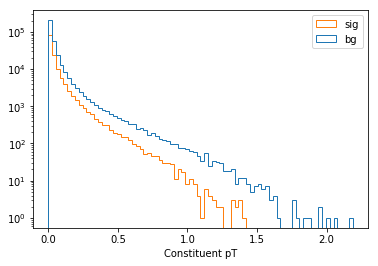

In [17]:
plt.hist([X[y==0][:,:,0].flatten(), X[y==1][:,:,0].flatten()],histtype='step',bins=80, label=['bg','sig']);
plt.yscale('log')
plt.xlabel('Constituent pT')
plt.legend();

In [18]:
# build and return three keras NN models: (classifier, adv, composed)
# The classifier takes `ntrk` constituents from a leading jet, and outputs [0,1]
# The adversary takes `ntrk` constituents, and outputs the same shape with the 4-vectors perturbed
# The composed model is the result of the classifier applied to adversary outputs, i.e. output=adv(cls(input))

def mk_model(ntrk):
    K.clear_session()
    
    classifier_input = layers.Input((ntrk,3))
    
    H = classifier_input
    
    H = layers.Flatten()(H)
    
    for _ in range(2):
        H = layers.Dense(128, activation='relu')(H)
    
    H = layers.Dense(2, activation='softmax')(H)
    
    classifier = Model(classifier_input, H)
    
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    adv_input = layers.Input((ntrk,3))
    H = adv_input
    
    
    pt = layers.Lambda(lambda x: x[:,:,0:1])(H)
    eta = layers.Lambda(lambda x: x[:,:,1:2])(H)
    phi = layers.Lambda(lambda x: x[:,:,2:3])(H)
    
    
    def pt_reg(pt_weights):
        #return 100*K.mean(K.square(K.sum(pt_weights, axis=-1)))
        return 1e-2*K.sum(K.square(pt_weights))
    
    H = layers.Flatten()(H)
    
    H = layers.Dense(256, activation='relu')(H)
    H = layers.Dense(256, activation='relu')(H)
    
    H = layers.Dense(ntrk, activation='relu', activity_regularizer=pt_reg)(H)
    H = layers.Reshape((-1,1))(H)
    
    pt_mod = layers.Lambda(lambda x: x[0]+x[1])([pt, H])
    
    adv_output = layers.Concatenate()([pt_mod,eta,phi])
    
        
    adv = Model(adv_input, adv_output)
    
    comp_input = layers.Input((ntrk,3))
    comp_output = classifier(adv(comp_input))
    comp = Model(comp_input, comp_output)
    
    classifier.trainable = False
    comp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    classifier.trainable = True
    
    return classifier, adv, comp

In [19]:
classifier, adv, comp = mk_model(ntrk)

classifier.summary()
adv.summary()

# NB you need to set the classifier weights to be untrainable when using the composed model.
classifier.trainable=False
comp.summary()
classifier.trainable=True

classifier_losses = []
classifier_val_losses = []

adv_losses = []
adv_val_losses = []

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 3)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12416     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 29,186
Trainable params: 29,186
Non-trainable params: 0
_________________________________________________________________
__________________________________________________________________________________________________
Layer (type)                    Output 

## Train a simple signal/bg classifier

In [20]:
# train the signal classifier first
epochs = 8
batch_size = 64

lr = 1e-4

K.set_value(classifier.optimizer.lr, lr)

try:
    classifier.fit(X_train, to_categorical(y_train,2),
              validation_data=(X_val, to_categorical(y_val,2)),
              batch_size=batch_size, epochs=epochs)
except KeyboardInterrupt:
    pass

classifier_losses.extend(classifier.history.history['loss'])
classifier_val_losses.extend(classifier.history.history['val_loss'])

Train on 12513 samples, validate on 2240 samples
Epoch 1/8
12513/12513 [==============================] - 1s 109us/step - loss: 0.6126 - acc: 0.7061 - val_loss: 0.6001 - val_acc: 0.7210
Epoch 2/8
12513/12513 [==============================] - 1s 71us/step - loss: 0.6015 - acc: 0.7096 - val_loss: 0.5968 - val_acc: 0.7196
Epoch 3/8
12513/12513 [==============================] - 1s 73us/step - loss: 0.5971 - acc: 0.7103 - val_loss: 0.5935 - val_acc: 0.7196
Epoch 4/8
12513/12513 [==============================] - 1s 76us/step - loss: 0.5934 - acc: 0.7107 - val_loss: 0.5913 - val_acc: 0.7174
Epoch 5/8
12513/12513 [==============================] - 1s 88us/step - loss: 0.5903 - acc: 0.7115 - val_loss: 0.5913 - val_acc: 0.7183
Epoch 6/8
12513/12513 [==============================] - 1s 70us/step - loss: 0.5888 - acc: 0.7133 - val_loss: 0.5890 - val_acc: 0.7183
Epoch 7/8
12513/12513 [==============================] - 1s 74us/step - loss: 0.5865 - acc: 0.7142 - val_loss: 0.5881 - val_acc: 0.718

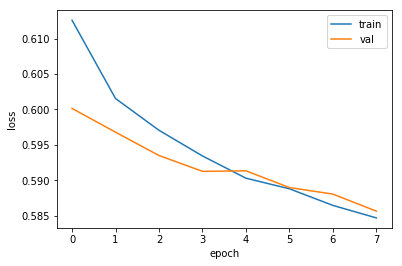

In [21]:
plt.plot(classifier_losses, label='train')
plt.plot(classifier_val_losses, label='val')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend();

## train an adversary to modify jet constituents to fool classifier

In [22]:
# Once the classifier is trained to a satisfactory level, we can freeze its weights
# and train to adversary, by training the composed model to maximize the opposite classification.
epochs = 32
batch_size = 64

lr = 1e-4

K.set_value(comp.optimizer.lr, lr)

classifier.trainable = False
try:
    comp.fit(X_train, to_categorical(y_train_flipped, 2),
             validation_data=(X_val, to_categorical(y_val_flipped, 2)),
             batch_size=batch_size, epochs=epochs, verbose=2)
except KeyboardInterrupt:
    pass

classifier.trainable = True

adv_losses.extend(comp.history.history['loss'])
adv_val_losses.extend(comp.history.history['val_loss'])

Train on 12513 samples, validate on 2240 samples
Epoch 1/32
 - 1s - loss: 1.2127 - acc: 0.2858 - val_loss: 1.0508 - val_acc: 0.2812
Epoch 2/32
 - 1s - loss: 1.0522 - acc: 0.2848 - val_loss: 1.0449 - val_acc: 0.2812
Epoch 3/32
 - 1s - loss: 1.0492 - acc: 0.2845 - val_loss: 1.0436 - val_acc: 0.2812
Epoch 4/32
 - 1s - loss: 1.0485 - acc: 0.2844 - val_loss: 1.0431 - val_acc: 0.2817
Epoch 5/32
 - 1s - loss: 1.0482 - acc: 0.2843 - val_loss: 1.0429 - val_acc: 0.2817
Epoch 6/32
 - 1s - loss: 1.0481 - acc: 0.2843 - val_loss: 1.0427 - val_acc: 0.2817
Epoch 7/32
 - 1s - loss: 1.0481 - acc: 0.2844 - val_loss: 1.0427 - val_acc: 0.2817
Epoch 8/32
 - 1s - loss: 1.0480 - acc: 0.2844 - val_loss: 1.0426 - val_acc: 0.2817
Epoch 9/32
 - 1s - loss: 1.0475 - acc: 0.2844 - val_loss: 1.0410 - val_acc: 0.2817
Epoch 10/32
 - 1s - loss: 1.0466 - acc: 0.2844 - val_loss: 1.0408 - val_acc: 0.2817
Epoch 11/32
 - 1s - loss: 1.0463 - acc: 0.2844 - val_loss: 1.0409 - val_acc: 0.2817
Epoch 12/32
 - 1s - loss: 1.0462 - a

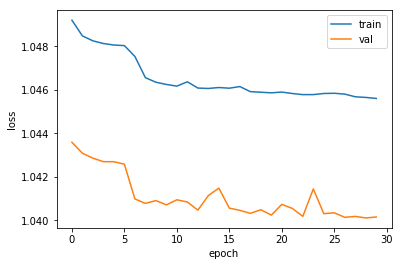

In [23]:
plt.plot(adv_losses[2:], label='train')
plt.plot(adv_val_losses[2:], label='val')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend();

In [24]:
classifier.evaluate(X_val, to_categorical(y_val, 2))

2240/2240 [==============================] - 0s 48us/step


[0.5856513989823205, 0.7183035714285714]

In [25]:
classifier.evaluate(adv.predict(X_val), to_categorical(y_val, 2))

2240/2240 [==============================] - 0s 60us/step


[0.5858022536550249, 0.7183035714285714]

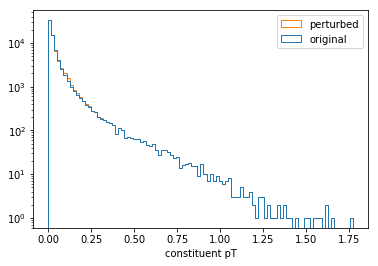

In [26]:
# plot the pT of the constituents before/after being perturbed by the adversary
plt.hist([X_val[:,:,0].flatten(), adv.predict(X_val)[:,:,0].flatten()], bins=100, histtype='step', label=['original','perturbed']);
plt.yscale('log')
plt.xlabel("constituent pT")
plt.legend();

## per-event adversarial examples using FGSM

In [27]:
# pick a particular jet, and initialize the adversarial example with its values. also initialize the adversarial noise with zeros

jet_index = 0
x = X_val[jet_index:jet_index+1]
x_adv = x.copy()
x_noise = np.zeros_like(x)

prediction_history = [classifier.predict(x)[0,0]]

In [28]:
# Define the epsilons in the (pt, eta, phi) directions
epsilon = (1e-4,1e-2,1e-2)
nstep = 16

# Then loop for the desired number of iterations to update the adversarial
# noise using the classifier loss gradient:

sess = K.get_session()
epsilon = K.reshape(K.constant(epsilon), (1,1,3))
for _ in range(nstep):
    loss = -1*K.categorical_crossentropy(np.array([0,1]), classifier.get_output_at(0))
    grads = K.gradients(loss, classifier.get_input_at(0))
    delta = K.sign(grads[0])
    #delta = grads[0]
    x_noise = x_noise + delta
    
    x_adv = x_adv + epsilon*delta
    x_adv = sess.run(x_adv, feed_dict={classifier.get_input_at(0):x})
    prediction_history.append(classifier.predict(x_adv)[0,0])

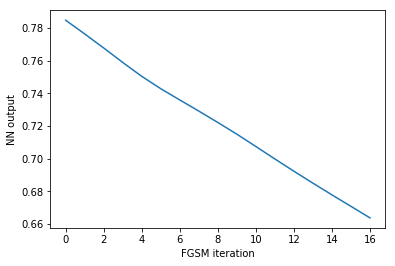

In [29]:
plt.plot(prediction_history)
plt.xlabel("FGSM iteration")
plt.ylabel("NN output");

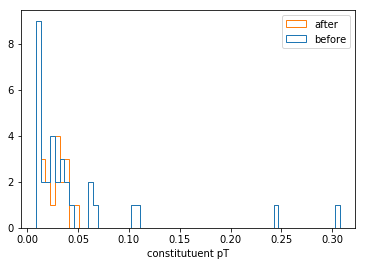

In [30]:
# plot the pT of the jet constituents before / after the adversarial perturbation
plt.hist([x[:,:,0].flatten(), x_adv[:,:,0].flatten()], histtype='step', bins=64, label=['before','after']);
plt.xlabel("constitutuent pT")
plt.legend();

In [31]:
# re-cluster the constituents to see if there's any effect on the jet-level kinematics:

jet_before = cluster_jets(x, ntrk=ntrk, minpt=0, gev=True)[0][0]
jet_after = cluster_jets(x_adv, ntrk=ntrk, minpt=0, gev=True)[0][0]

print("             pT    |      eta     |     phi      |    mass")
print("before:  %.3e |  %+.3e  |  %+.3e  |  %.3e" % tuple(jet_before))
print("after:   %.3e |  %+.3e  |  %+.3e  |  %.3e" % tuple(jet_after))

             pT    |      eta     |     phi      |    mass
before:  1.481e+03 |  -8.026e-01  |  -2.051e-01  |  4.552e+02
after:   1.457e+03 |  -7.217e-01  |  -1.474e-01  |  5.484e+02


In [32]:
# print out the raw residual of the consituents
x-x_adv

array([[[ 0.00159978, -0.15999985, -0.16000003],
        [ 0.00160003, -0.15999985, -0.15999995],
        [ 0.00160003, -0.15999985, -0.15999995],
        [ 0.00160003, -0.15999985,  0.15999985],
        [-0.00160002,  0.15999985,  0.15999985],
        [ 0.00160003, -0.15999985,  0.15999998],
        [-0.00160003,  0.15999985,  0.15999988],
        [-0.00160003,  0.15999985, -0.16      ],
        [-0.00160003, -0.15999985,  0.15999998],
        [-0.00160003, -0.15999985, -0.16      ],
        [-0.00160003, -0.15999985, -0.15999991],
        [-0.00160003, -0.15999985, -0.16000001],
        [-0.00160003, -0.15999985,  0.15999999],
        [ 0.00160001, -0.15999985,  0.15999985],
        [ 0.0016    , -0.15999985, -0.15999995],
        [-0.0016    ,  0.15999985, -0.15999994],
        [-0.0016    ,  0.15999985, -0.16000001],
        [ 0.0016    ,  0.15999985, -0.16      ],
        [-0.0016    , -0.15999985, -0.16000001],
        [-0.0016    , -0.15999985,  0.15999985],
        [ 0.0016    